## Reference :

- https://www.kaggle.com/c/nyc-taxi-trip-duration/data

## Process :

    - 0 LOAD DATA 
    - 1 SIMPLE FEATURE EXTRACT
    - 2 DATA OVERVIEW
        -2.1 vendor_id
        -2.2 pickup_day & dropoff_day
        -2.3 passenger_count
        -2.4 pickup & dropoff locations (lon & lat )
        -2.5 store_and_fwd_flag
        -2.6 trip_duration
    - 3 FEATURE ENGINEERING 
    - 4 FEATURE ANALYSIS 
    - 5 DATA CLEANING ANALYSIS 



- File descriptions

>- train.csv - the training set (contains 1458644 trip records)
- test.csv - the testing set (contains 625134 trip records)
- sample_submission.csv - a sample submission file in the correct format
    
    
- Data fields

>- id - a unique identifier for each trip
- vendor_id - a code indicating the provider associated with the trip record
- pickup_datetime - date and time when the meter was engaged
- dropoff_datetime - date and time when the meter was disengaged
- passenger_count - the number of passengers in the vehicle (driver entered value)
- pickup_longitude - the longitude where the meter was engaged
- pickup_latitude - the latitude where the meter was engaged
- dropoff_longitude - the longitude where the meter was disengaged
- dropoff_latitude - the latitude where the meter was disengaged
- store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
- trip_duration - duration of the trip in seconds


In [1]:
# load basics library 

import pandas as pd, numpy as np
%matplotlib inline
%pylab inline
import seaborn  as sns 
import matplotlib.pyplot as plt


Populating the interactive namespace from numpy and matplotlib


## - 0) Load data

In [2]:
# load data

df_train = pd.read_csv('~/NYC_Taxi_Trip_Duration/data/train.csv')
df_test = pd.read_csv('~/NYC_Taxi_Trip_Duration/data/test.csv')
sampleSubmission = pd.read_csv('~/NYC_Taxi_Trip_Duration/data/sample_submission.csv')

In [3]:
df_train.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663


## -1) Simple feature extract 

In [4]:
# help function


def basic_feature_extract(df):
    df_= df.copy()
    # pickup
    df_["pickup_date"] = pd.to_datetime(df_.pickup_datetime.apply(lambda x : x.split(" ")[0]))
    df_["pickup_hour"] = df_.pickup_datetime.apply(lambda x : x.split(" ")[1].split(":")[0])
    df_["pickup_year"] = df_.pickup_datetime.apply(lambda x : x.split(" ")[0].split("-")[0])
    df_["pickup_month"] = df_.pickup_datetime.apply(lambda x : x.split(" ")[0].split("-")[1])
    df_["pickup_weekday"] = df_.pickup_datetime.apply(lambda x :pd.to_datetime(x.split(" ")[0]).weekday())
    # dropoff
    # in case test data dont have dropoff_datetime feature
    try:
        df_["dropoff_date"] = pd.to_datetime(df_.dropoff_datetime.apply(lambda x : x.split(" ")[0]))
        df_["dropoff_hour"] = df_.dropoff_datetime.apply(lambda x : x.split(" ")[1].split(":")[0])
        df_["dropoff_year"] = df_.dropoff_datetime.apply(lambda x : x.split(" ")[0].split("-")[0])
        df_["dropoff_month"] = df_.dropoff_datetime.apply(lambda x : x.split(" ")[0].split("-")[1])
        df_["dropoff_weekday"] = df_.dropoff_datetime.apply(lambda x :pd.to_datetime(x.split(" ")[0]).weekday())
    except:
        pass 
    return df_

# get weekday
import calendar

def get_weekday(df):
    list(calendar.day_name)
    df_=df.copy()
    df_['pickup_week_'] = pd.to_datetime(df_.pickup_datetime,coerce=True).dt.weekday
    df_['pickup_weekday_'] = df_['pickup_week_'].apply(lambda x: calendar.day_name[x])
    return df_

# get trip duration 
def get_duration(df):
    df_= df.copy()
    df_['trip_duration_cal'] = pd.to_datetime(df_['dropoff_datetime']) - pd.to_datetime(df_['pickup_datetime'])
    return df_
    



In [5]:
#pd.to_datetime(df_train.pickup_datetime,coerce=True).dt.weekday

In [6]:
# one may take few minutes 
df_train_ = basic_feature_extract(df_train)

In [7]:
df_train_ = get_duration(df_train_)
df_train_ = get_weekday(df_train_)

//anaconda/envs/g_dash/lib/python3.4/site-packages/ipykernel_launcher.py:30: FutureWarning: the coerce=True keyword is deprecated, use errors='coerce' instead


In [8]:
#df_train_.head(2)
#df_train_[['pickup_datetime','dropoff_datetime','trip_duration']]

In [9]:
#df_train_[['dropoff_datetime','dropoff_date','dropoff_hour','dropoff_year','dropoff_month']]


## - 2) Data overview

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


- train data set has  1458644 trip records (every ride per record),
    `no missing values` 

In [11]:
df_train_.head(1)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_month,pickup_weekday,dropoff_date,dropoff_hour,dropoff_year,dropoff_month,dropoff_weekday,trip_duration_cal,pickup_week_,pickup_weekday_
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.96463,40.765602,N,...,03,0,2016-03-14,17,2016,03,0,00:07:35,0,Monday


### 2-1) vendor_id

In [12]:
df_train.vendor_id.value_counts()

2    780302
1    678342
Name: vendor_id, dtype: int64

Vendor_id means id of vendors, here we can see there are 2 vendors serve 
in this NYC taxi record, they have `similar` ride counts

### 2-2) pickup_day & dropoff_day 

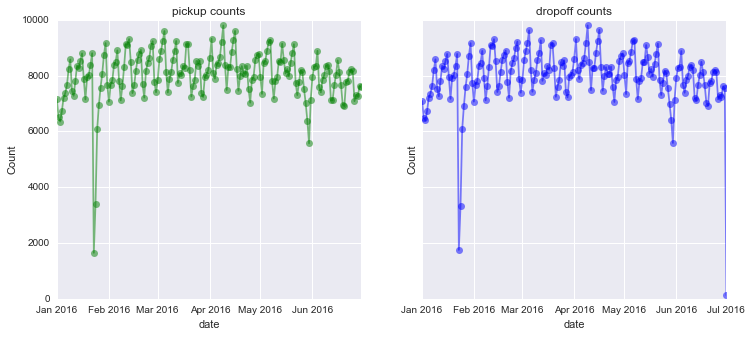

In [13]:
fig, ax = plt.subplots(ncols=2, sharey=True)
fig.set_size_inches(12, 5)

ax[0].plot(df_train_.groupby('pickup_date').count()['id'], 'go-', alpha=0.5)
ax[1].plot(df_train_.groupby('dropoff_date').count()['id'], 'bo-', alpha=0.5)

ax[0].set(xlabel='date', ylabel='Count',title="pickup counts")
ax[1].set(xlabel='date', ylabel='Count',title="dropoff counts")

plt.show()

- The orders countssudden fail in 2016-01-23, need to check deeper to see
  if this affect data quality 

- Averagely 7000 - 9000 counts of orders (pickup) per day.

### - 2-3) passenger_count

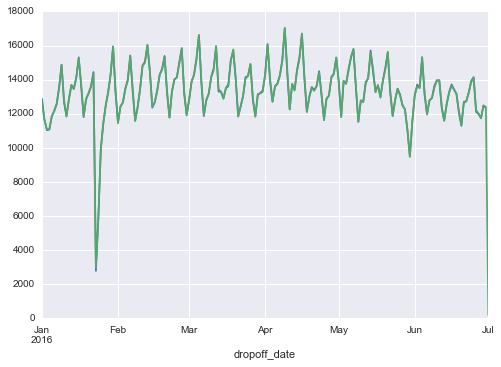

In [14]:
df_train_.groupby(['pickup_date']).sum()['passenger_count'].plot()
df_train_.groupby(['dropoff_date']).sum()['passenger_count'].plot()

In [15]:
df_train_.passenger_count.value_counts(sort=False)

0         60
1    1033540
2     210318
3      59896
4      28404
5      78088
6      48333
7          3
8          1
9          1
Name: passenger_count, dtype: int64

- Averagely 12k - 16k passengers per day 
- Most taxi take 1 passengers per ride, but some numbers like 0,7,8,9 
  maybe are outliers 

## 2-4) pickup  & dropoff locations (lon & lat )

In [16]:
# ref 
# https://www.kaggle.com/misfyre/in-depth-nyc-taxi-eda-also-w-animation
# folloing ref above, here I drop outliers and do geo data visualization 
# (drop data point > 95% and < 5%)

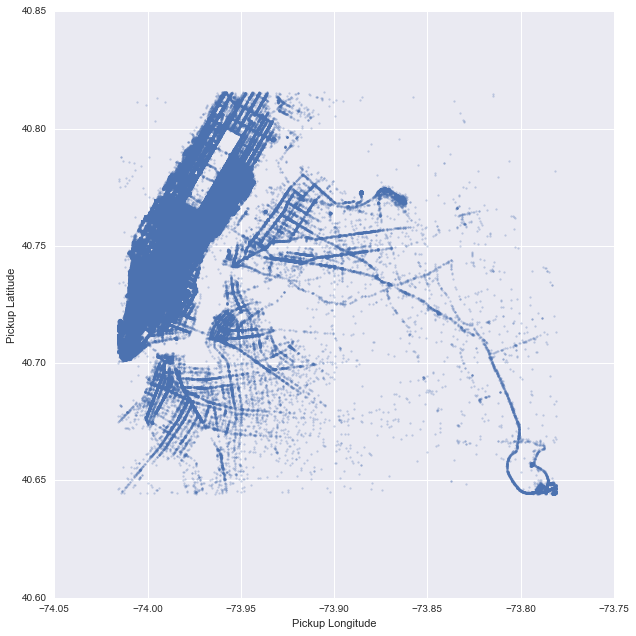

In [17]:
# pickup 
sns.lmplot(x="pickup_longitude", y="pickup_latitude", fit_reg=False, 
           size=9, scatter_kws={'alpha':0.3,'s':5}, data=df_train_[(
                 df_train_.pickup_longitude>df_train_.pickup_longitude.quantile(0.005))
               &(df_train_.pickup_longitude<df_train_.pickup_longitude.quantile(0.995))
               &(df_train_.pickup_latitude>df_train_.pickup_latitude.quantile(0.005))                           
               &(df_train_.pickup_latitude<df_train_.pickup_latitude.quantile(0.995))])

plt.xlabel('Pickup Longitude');
plt.ylabel('Pickup Latitude');
plt.show()

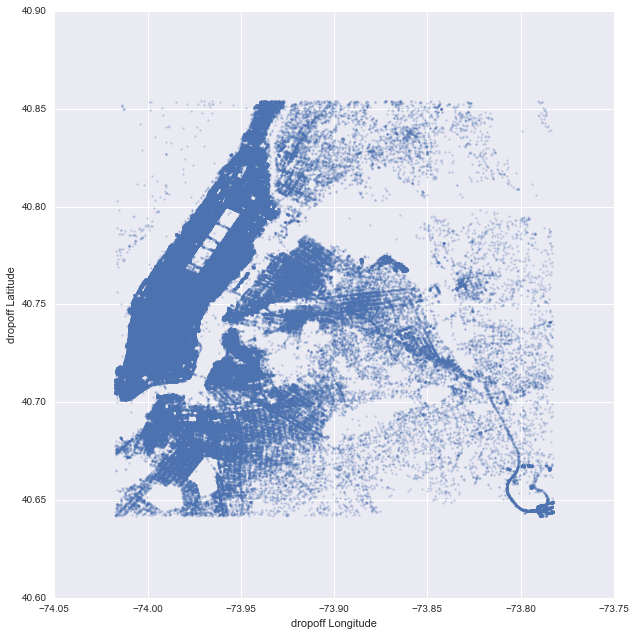

In [18]:
# dropoff 
sns.lmplot(x="dropoff_longitude", y="dropoff_latitude",fit_reg=False, 
           size=9, scatter_kws={'alpha':0.3,'s':5}, data=df_train_[(
                 df_train_.dropoff_longitude>df_train_.dropoff_longitude.quantile(0.005))
               &(df_train_.dropoff_longitude<df_train_.dropoff_longitude.quantile(0.995))
               &(df_train_.dropoff_latitude>df_train_.dropoff_latitude.quantile(0.005))                           
               &(df_train_.dropoff_latitude<df_train_.dropoff_latitude.quantile(0.995))])

plt.xlabel('dropoff Longitude');
plt.ylabel('dropoff Latitude');
plt.show()

##### We get an very interesting outcome from this visualization : 

1. Manhattan get `MOST` of pickup orders, since many people work there,
    it makes sense it's the place where main demands from 
    
2. Many dropoff orders `outside the  Manhattan area ` maybe because 
people work/srudy in Manhattan, but live in areas like Queens/Brooklyn..

3. JFK Airport (the point in east north) maybe be a `key point` affect 
duration, since many orders back and forth within the city and JFK,
it's a `not short` distance, may affect duration prediction alot.

## 2-5) store_and_fwd_flag	

In [19]:
df_train_.store_and_fwd_flag.value_counts()

N    1450599
Y       8045
Name: store_and_fwd_flag, dtype: int64

About  0.5% (8045/1450599) of orders (store_and_fwd_flag=Y) are not sent  immediately to vendor server, but hold in  the memory of taxi, need to investigate if this affact data quality as well 

## 2-6) trip_duration 

In [20]:
df_train_.head(1)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_month,pickup_weekday,dropoff_date,dropoff_hour,dropoff_year,dropoff_month,dropoff_weekday,trip_duration_cal,pickup_week_,pickup_weekday_
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.96463,40.765602,N,...,03,0,2016-03-14,17,2016,03,0,00:07:35,0,Monday


In [21]:
#df_train_.columns

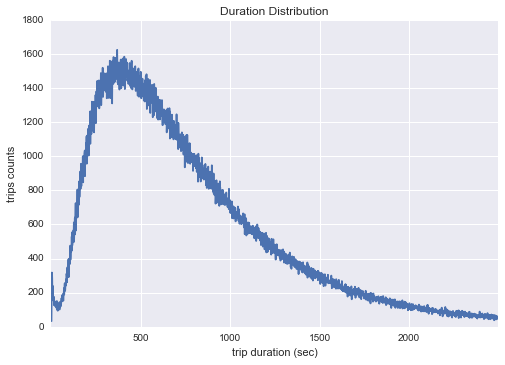

In [22]:
# trip duration overall distribution 
# remove outlier by only taking data under .97 quantile

tripduration = df_train_[df_train_.trip_duration < df_train_.trip_duration.quantile(.97)]
tripduration.groupby('trip_duration').count()['id'].plot()

plt.xlabel('trip duration (sec)')
plt.ylabel('trips counts')
plt.title('Duration Distribution')

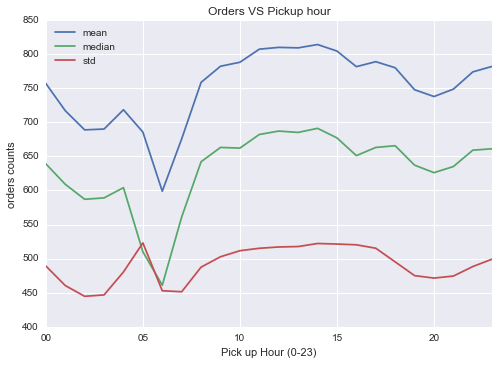

In [23]:
# pivot table
# http://pbpython.com/pandas-pivot-table-explained.html

#tripduration = df_train_[df_train_.trip_duration < df_train_.trip_duration.quantile(.97)]


pd.pivot_table(tripduration, index='pickup_hour' ,aggfunc=np.mean)['trip_duration'].plot(label='mean')
pd.pivot_table(tripduration, index='pickup_hour' ,aggfunc=np.median)['trip_duration'].plot(label='median')
pd.pivot_table(tripduration, index='pickup_hour' ,aggfunc=np.std)['trip_duration'].plot(label='std')

plt.legend(loc=0)
plt.xlabel('Pick up Hour (0-23)')
plt.ylabel('orders counts ')
plt.title('Orders VS Pickup hour')
plt.show()

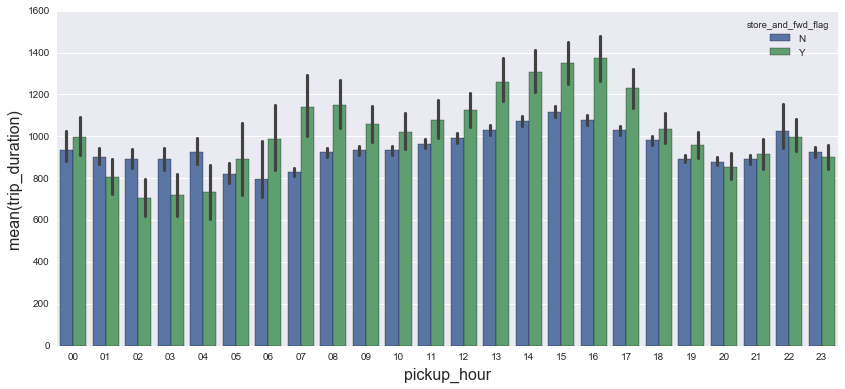

In [24]:
# plots trip duration on store_and_fwd_flag 
# (send back data to vendor server directly or save in taxi then upload because internet issues)

plt.figure(figsize=(14,6))
sns.barplot(x='pickup_hour',y='trip_duration',data=df_train_,hue='store_and_fwd_flag')
plt.xlabel('pickup_hour',fontsize=16)
plt.ylabel('mean(trip_duration)',fontsize=16)


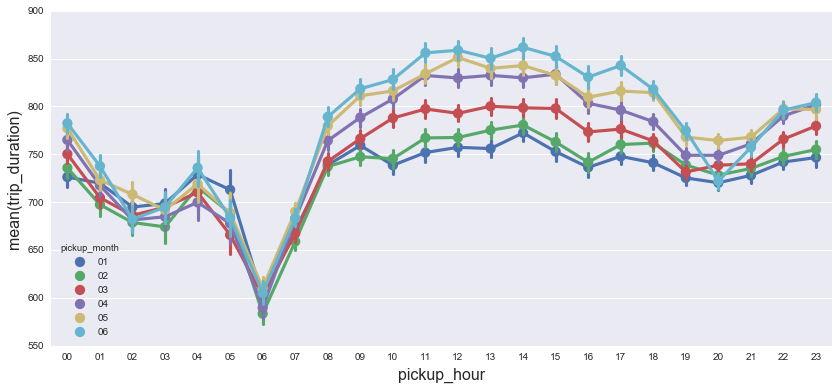

In [25]:
#  duration VS. pickup hour in given months 

plt.figure(figsize=(14,6))
sns.pointplot(x='pickup_hour',y='trip_duration',data=tripduration,hue='pickup_month')
plt.xlabel('pickup_hour',fontsize=16)
plt.ylabel('mean(trip_duration)',fontsize=16)

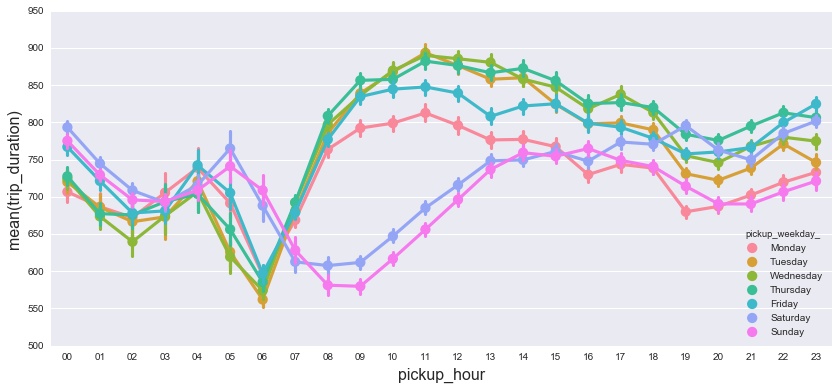

In [26]:
#  duration VS. pickup hour in weekdays 


plt.figure(figsize=(14,6))
sns.pointplot(x='pickup_hour',y='trip_duration',data=tripduration,hue='pickup_weekday_',hue_order=list(calendar.day_name))
plt.xlabel('pickup_hour',fontsize=16)
plt.ylabel('mean(trip_duration)',fontsize=16)

In [27]:
df_train_.groupby('trip_duration').count()['id'].tail(5)

# 86392 sec means 23 hours 
# 2049578 sec means 23 days 
# which are all no make sense 

trip_duration
86392      1
1939736    1
2049578    1
2227612    1
3526282    1
Name: id, dtype: int64

#### Duration is the prediction target in this competition :

1. Most trips finished within `6-10 minute` (400-600 sec)
2. Some trips take too long/too fast are obvious wrong, maybe because 
of tech/maunal operation issues, should filter them in following process

3. Duration are `longer ` when `store_and_fwd_flag = Y`, maybe because 
   internet is bad in areas off downtowm, imply taxi drivers `much longer`
   relatively.
   
4. Duration `RISE` dramtically from 7 AM to 10 AM, maybe owing to traffic 
jam and people start moving to NYC from nearyby areas when daytime

5. Months only affect duration `a little bit` ; while `pickup hours` seems may be infulence that more 

6. `Weekday` is apparently relative to duration. `Duration are high duing wokday (Mon.-Fri.)`, since people work, taxi are much more busy to take people from Manhattan <---> outside Manhattan
